In [195]:
import math
import random
import numpy
import names
import typing
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px
from pyvis.network import Network
from collections.abc import Sequence

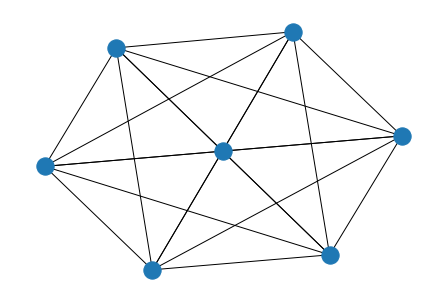

In [50]:
G = nx.complete_graph(7)
nx.draw(G)
# nx_graph = nx.cycle_graph(10)
# nx.draw(nx_graph)

a2


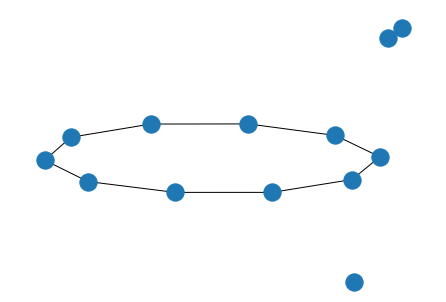

In [15]:
nx_graph = nx.cycle_graph(10)
nx_graph.nodes[1]['title'] = 'Number 1'
nx_graph.nodes[1]['group'] = 1
nx_graph.nodes[3]['title'] = 'I belong to a different group!'
nx_graph.nodes[3]['group'] = 10
nx_graph.add_node(20, size=20, title='couple', group=2)
nx_graph.add_node(21, size=15, title='couple', group=2)
nx_graph.add_edge(20, 21, weight=5)
nx_graph.add_node(25, size=25, label='lonely', title='lonely node', group=3)
nx.draw(nx_graph)

In [228]:

class AgentModelConfig:
    def __init__(
            self,
            agent_amount: int = 100,
            weight_amount_speed_rate: float = 0.6,
            children_y_margin: int = 50,
            children_x_margin: int = 50,
            graph_height: int = 1000,
            graph_width: int = 1000,
            hierarchy_levels: int = 6,
            lowest_level_percent: int = 60,
        ) -> None:
        self.children_y_margin = children_y_margin
        self.children_x_margin = children_x_margin
        self.graph_height = graph_height
        self.graph_width = graph_width
        self.hierarchy_levels  = hierarchy_levels
        self.lowest_level_percent = lowest_level_percent
        self.weight_amount_speed_rate = weight_amount_speed_rate
        self.agent_amount = agent_amount

class Agent:
    def __init__(self, config: AgentModelConfig, index: int, name: str, tier: int = 0, parent = None) -> None:
        self.index = index
        self.name = name
        self.tier = tier
        self.parent: Agent = parent
        self.plot_x = 0
        self.plot_y = 0

    def __hash__(self) -> int:
        return hash(self.index)

    def __eq__(self, other) -> bool:
        if not isinstance(other, Agent):
            return False
        return self.index == other.index

class AgentNetwork:
    def __init__(self, config: AgentModelConfig) -> None:
        self.agents: list[Agent] = []
        self.config = config
        self.hydrate()
        self.weighted_agent_amounts = self.get_weighted_agent_amounts()
        print(self.weighted_agent_amounts)
        self.assign_parents()
        # print(sum(self.weighted_agent_amounts))
        self.generate_random_trace()
        # self.test_print_agents()

    def __getitem__(self, items) -> typing.Union[Agent, Sequence[Agent]]:
        return self.agents[items]

    def __len__(self) -> int:
        return len(self.agents)

    def hydrate(self) -> None:
        self.agents = [Agent(
            config = self.config,
            index = i,
            name = names.get_full_name(),
        ) for i in range(self.config.agent_amount)]

    def assign_parents(self) -> None:
        pointer = 1
        parent_agents = []
        current_agents = []
        self.agents[0].parent = self.agents[0]
        for id_wam, weighted_agent_amount in enumerate(self.weighted_agent_amounts):
            for i in range(weighted_agent_amount):
                if pointer == len(self.agents):
                    continue
                current_agents.append(self.agents[pointer])
                self.agents[pointer].tier = id_wam + 1
                if id_wam == 0:
                    self.agents[pointer].parent = self.agents[0]
                else:
                    self.agents[pointer].parent = parent_agents[random.randint(0, len(parent_agents) - 1)]
                pointer += 1
            parent_agents = current_agents
            current_agents = []

    def generate_random_trace(self) -> None:
        for i in range(len(self.agents)):
            if self.agents[i].tier == 0:
                self.agents[i].plot_x = round(self.config.graph_width / 2)
                self.agents[i].plot_y = self.config.graph_height - 10
            self.agents[i].plot_x = random.randint(
                self.agents[i].parent.plot_x - self.config.children_x_margin,
                self.agents[i].parent.plot_x + self.config.children_x_margin
            )
            self.agents[i].plot_y = self.agents[i].parent.plot_y - self.config.children_y_margin

    def get_nx_edges(self):
        result = []
        for agent in self.agents:
            if agent.index == 0:
                continue
            result.append((agent, agent.parent, 1))
        return result

    def test_print_agents(self) -> None:
        for agent in self.agents:
            try:
                print(f'i={agent.index}, tier={agent.tier}, parent={agent.parent.index}, x={agent.plot_x}, y={agent.plot_y}')
            except AttributeError:
                print(f'i={agent.index}, tier={agent.tier}, parent=None, x={agent.plot_x}, y={agent.plot_y}')

    def get_weighted_agent_amounts(self) -> list[int]:
        """This function assumes that first hierarchy level always contains single agent"""
        total_parts = sum(range(self.config.hierarchy_levels))
        agent_amount = len(self.agents)
        part_size = round(agent_amount / total_parts / 2)
        i = 0
        amounts = []
        for level in range(self.config.hierarchy_levels - 1):
            weighted_count = round(pow(part_size, (level + 1) * self.config.weight_amount_speed_rate))
            if level == self.config.hierarchy_levels - 2:
                amounts.append(weighted_count - (sum(amounts, weighted_count) - agent_amount))
            else:
                amounts.append(weighted_count)
        return amounts

class AgentGraph:
    def __init__(self, agent_network: AgentNetwork) -> None:
        self.agent_network = agent_network
        self.nx_graph = nx.Graph()
        self.hydrate_nx_graph()

    def hydrate_nx_graph(self) -> None:
        self.nx_graph.add_nodes_from(self.agent_network)
        self.nx_graph.add_weighted_edges_from(self.agent_network.get_nx_edges())

    def convert_from_nx_to_ploty(self):
        edge_x = []
        edge_y = []
        for edge in self.nx_graph.edges():
            edge_x.append(edge[0].plot_x)
            edge_x.append(edge[1].plot_x)
            edge_x.append(None)
            edge_y.append(edge[0].plot_y)
            edge_y.append(edge[1].plot_y)
            edge_y.append(None)

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        )

        node_x = []
        node_y = []
        text = []
        for node in self.nx_graph.nodes():
            node_x.append(node.plot_x)
            node_y.append(node.plot_y)
            text.append(f'name: {node.name}, x:{node.plot_x}, y:{node.plot_y}')

        node_adjacencies = []
        for node, adjacencies in enumerate(self.nx_graph.adjacency()):
            node_adjacencies.append(len(adjacencies[1]))
            # node_text.append('# of connections: '+str(len(adjacencies[1])))

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            text = text,
            mode='markers',
            hoverinfo='text',
            marker=dict(
                showscale=True,
                colorscale='YlGnBu',
                reversescale=True,
                color=node_adjacencies,
                size=10,
                colorbar=dict(
                    thickness=15,
                    title='Node Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line_width=2)
        )
        return [edge_trace, node_trace]

    def draw_ploty_graph(self) -> None:
        fig = go.Figure(
            data=self.convert_from_nx_to_ploty(),
            layout=go.Layout(
            title='Agent Network',
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[ dict(
                text="",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) ],
            xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
            yaxis=dict(showgrid=True, zeroline=True, showticklabels=True))
        )
        fig.show()

    def draw_visjs_graph(self) -> None:
        net = Network('1000px', '1000px')
        for node in nx_graph.nodes():
            net.add_node(node.index, label=node.name)
        for edge in nx_graph.edges():
            net.add_edge(edge[0].index, edge[1].index)
        # net.from_nx(nx_graph)
        net.toggle_physics(False)
        net.show_buttons(filter_=[
            'physics',
            'layout',
            # 'edges'
        ])
        net.show('graph.html')

def main():
    conf            = AgentModelConfig()
    agent_network   = AgentNetwork(conf)
    graph           = AgentGraph(agent_network)

    graph.draw_ploty_graph()
    graph.draw_visjs_graph()

    # agent_network[0].name = 'asd'
    # for node in graph.nx_graph.nodes():
    #     print(node.name)

if __name__ == "__main__":
    main()







[2, 4, 7, 14, 73]


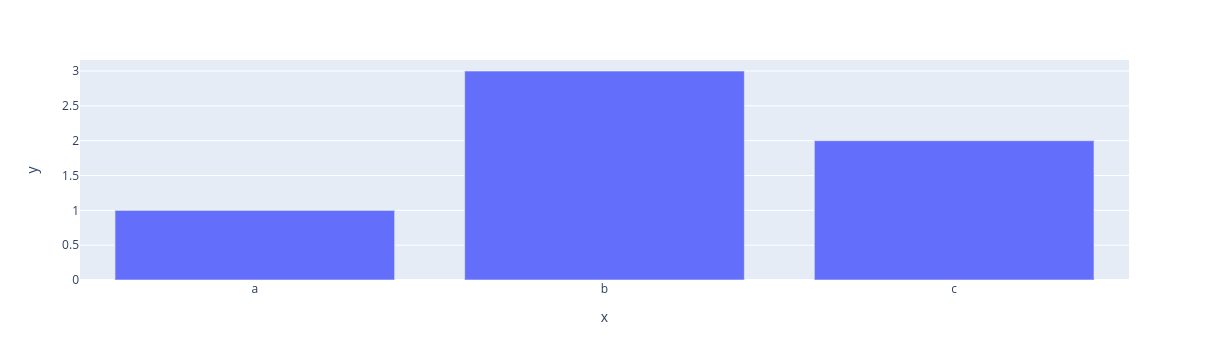

In [39]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()